<a href="https://colab.research.google.com/github/IbrahimRefaay/Zindi-Rice-disease/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
     

Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [2]:
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [3]:
!mkdir -p images
!unzip -q /content/drive/MyDrive/Images.zip -d images

In [4]:
!ls 

drive  images  sample_data


In [5]:
from fastai.vision.all import *

In [6]:
train = pd.read_csv('/content/Train.csv')
print(train.shape)
train.head()

(5340, 2)


,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


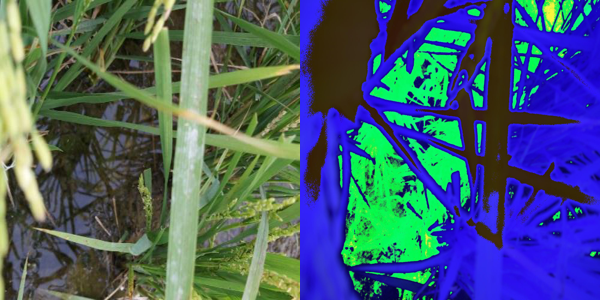

In [7]:
out = Image.new('RGB', (600, 300))
out.paste(Image.open('/content/images/id_004wknd7qd.jpg').resize((300, 300)), (0, 0))
out.paste(Image.open('/content/images/id_004wknd7qd_rgn.jpg').resize((300, 300)), (300, 0))
out

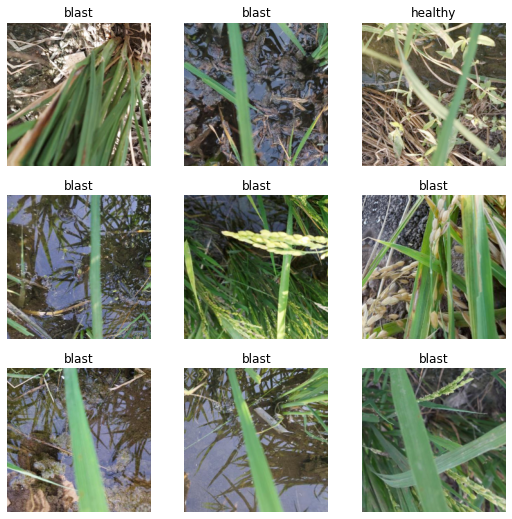

In [8]:
# Create the dataloaders
train_rgb = train[~train.Image_id.str.contains('_rgn')] # Just the RGB images
dls = ImageDataLoaders.from_df(train_rgb, fn_col='Image_id', label_col='Label', 
                               folder='images', item_tfms=Resize(400),
                               batch_tfms = aug_transforms(size=224))
dls.show_batch() # Note the augmentation applied to the images!

In [9]:
k=list(np.arange(0.0001,1, 0.001))[:3]

In [10]:
k

[0.0001, 0.0011, 0.0021]

In [11]:
learn = vision_learner(dls, resnet101, metrics=error_rate, lr=0.0025)
learn.fine_tune(20)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.338851,1.019120,0.265918,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.789652,0.470882,0.155431,00:40
1,0.605036,0.321832,0.102996,00:40
2,0.490504,0.276065,0.091760,00:40
3,0.394270,0.250889,0.080524,00:41
4,0.297650,0.249425,0.074906,00:41
5,0.256723,0.301401,0.088015,00:41
6,0.229574,0.224817,0.063670,00:41
7,0.183129,0.193915,0.054307,00:41
8,0.131740,0.195443,0.054307,00:41
9,0.112090,0.214715,0.059925,00:41


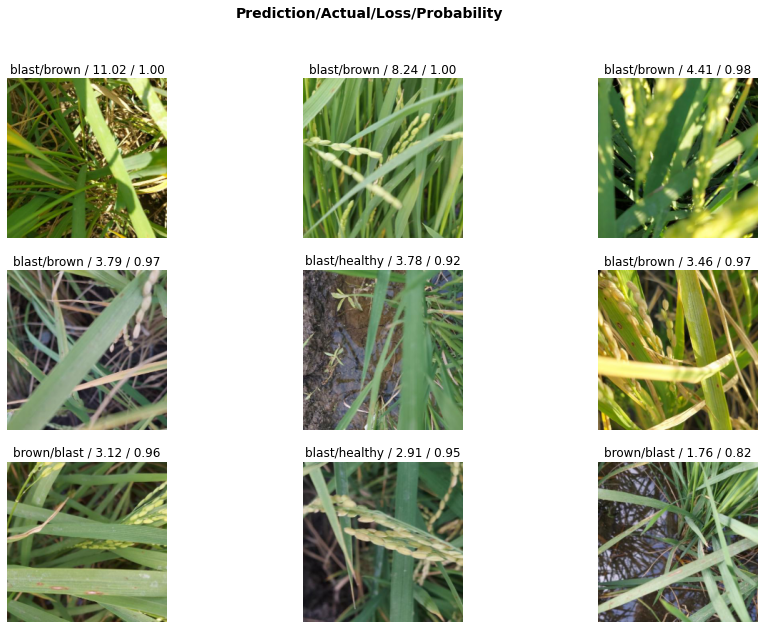

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

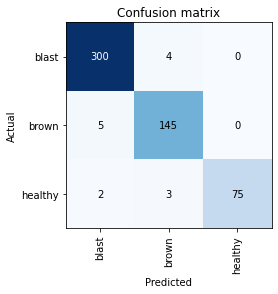

In [14]:
interp.plot_confusion_matrix()


In [15]:

test = pd.read_csv('Test.csv')
test = test[~test.Image_id.str.contains('_rgn')] # Just the RGB images

In [16]:
preds, _ = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities
preds

TensorBase([[1.0000e+00, 6.3872e-07, 7.0864e-07],
            [1.1306e-02, 9.8848e-01, 2.1883e-04],
            [7.0886e-01, 2.8423e-01, 6.9089e-03],
            ...,
            [9.9915e-01, 8.2936e-04, 1.6099e-05],
            [9.9995e-01, 1.5066e-07, 5.3158e-05],
            [2.5878e-03, 4.1195e-08, 9.9741e-01]])

In [17]:
print(train_rgb.shape), print(test.shape)


(2670, 2)
(1145, 1)


(None, None)

In [18]:

submission = pd.DataFrame({'Image_id': test['Image_id']})
for i, label in enumerate(learn.dls.vocab):
  submission[label] = preds[:,i].numpy()
submission.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999999,6.387240e-07,7.086373e-07
2,id_01hu05mtch.jpg,0.011306,9.884752e-01,2.188310e-04
4,id_030ln10ewn.jpg,0.708865,2.842266e-01,6.908879e-03
6,id_03z57m8xht.jpg,0.999997,4.646149e-07,2.434717e-06
8,id_04ngep1w4b.jpg,0.999102,7.484598e-04,1.494144e-04


In [32]:
print("Acuuracy :",1-learn.validate()[1])

Acuuracy : 0.9737827721983194


In [24]:
from sklearn.metrics import precision_score

# Get predictions and targets for the validation set
preds, targets = learn.get_preds()

# Convert predictions and targets to numpy arrays
preds = preds.numpy()
targets = targets.numpy()

# Compute precision
precision = precision_score(targets, preds.argmax(axis=1), average='macro')

# Print precision
print('Precision:', precision)


Precision: 0.9770486884964855


In [29]:
from sklearn.metrics import f1_score

# Get the predicted and true labels for the validation set
preds, targets = learn.get_preds()

# Convert the predictions and targets to numpy arrays
preds = preds.numpy().argmax(axis=1)
targets = targets.numpy()

# Compute the F1 score for each class
f1_scores = f1_score(targets, preds, average=None)

# Compute the mean F1 score across all classes
mean_f1_score = f1_scores.mean()

# Print the F1 scores and mean F1 score
print('F1 scores:', f1_scores)
print('Mean F1 score:', mean_f1_score)


F1 scores: [0.98199673 0.9602649  0.96774194]
Mean F1 score: 0.9700011876079001
